In [28]:
SHUFFLE = True
BATCH_SIZE = 20
TEST_TRAIN = 0.2

KERNEL_SIZE = (100, 50, 25, 12, 6)
N_KERNELS = (10,20,40,80,160)
POOL_SIZE = (5,2,5,2)


DROPOUT = (0.1, 0.2, 0.3, 0.4, 0.5)
DENSE_LEN = 10

In [29]:
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling2D, Dropout, BatchNormalization, Flatten, ELU
from keras.models import Model
from keras.models import load_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import optimizers
from keras.initializers import Orthogonal as orth
from keras.callbacks import TensorBoard, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

paths = ['/home/amplifier/home/DATASETS/BCI_0101T_TD.mat',
         '/home/amplifier/home/DATASETS/BCI_0202T_TD.mat',
        '/home/amplifier/home/DATASETS/BCI_0303T_TD.mat',
        '/home/amplifier/home/DATASETS/BCI_0403T_TD.mat',
        '/home/amplifier/home/DATASETS/BCI_0503T_TD.mat',
        '/home/amplifier/home/DATASETS/BCI_0603T_TD.mat',
        '/home/amplifier/home/DATASETS/BCI_0703T_TD.mat',
        '/home/amplifier/home/DATASETS/BCI_0801T_TD.mat']

def load_file(file):
    print(file)
    mat_contents = sio.loadmat(file)
    X = mat_contents['X']
    Y = mat_contents['Z']

    if X.shape[1]<X.shape[2]:
        X = np.transpose(X,[0,2,1])

    if Y.shape[1] > Y.shape[0]:
        Y = Y.T

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_TRAIN, shuffle=SHUFFLE)

    # convert to float64 for numerical stability:
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')


    # one hot encode the labels:
    onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
    y_train = onehot_encoder.fit_transform(y_train)
    y_test = onehot_encoder.fit_transform(y_test)

    # convert to float16 to save space:
    x_train = x_train.astype('float16')
    y_train = y_train.astype('float16')
    x_test = x_test.astype('float16')
    y_test = y_test.astype('float16')

    leng = X.shape[1] # if you work in the FD, this is the height of the sample time-frequency image, othewise EEG channels
    chan = X.shape[2] # if you work in the FD, this is the width of the sample time-frequency image, othewise time samples of EEG signal

    if len(X.shape)==3:
        streams = 1 # this is EEG channels if you work with frequency domain, in the TD streams = 1
    if len(X.shape)==4:
        streams = X.shape[3] # this is EEG channels if you work with frequency domain, in the TD streams = 1
    
    return x_train, x_test, y_train, y_test, leng, chan, streams



def conv_net(leng):
    input_img = Input(shape=(leng, chan))  # adapt this if using `channels_first` image
    input_norm = BatchNormalization(axis=1)(input_img)
    e1 = Conv1D(N_KERNELS[0], KERNEL_SIZE[0], activation=ELU(alpha=1.0), padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(input_norm)
#     e2 = MaxPooling2D(POOL_SIZE, padding='same')(e1)
    e2 = MaxPooling1D(pool_size=POOL_SIZE[0], strides=None, padding='valid')(e1)
    e2b = BatchNormalization(axis=1)(e2)
    e2a = Dropout(DROPOUT[0])(e2b)
    e3 = Conv1D(N_KERNELS[1], KERNEL_SIZE[1], activation=ELU(alpha=1.0), padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(e2a)
#     e4 = MaxPooling2D(POOL_SIZE, padding='same')(e3)
    e4 = MaxPooling1D(pool_size=POOL_SIZE[1], strides=None, padding='valid')(e3)
    e4b = BatchNormalization(axis=1)(e4)
    e4a = Dropout(DROPOUT[1])(e4b)
    e5 = Conv1D(N_KERNELS[2], KERNEL_SIZE[2], activation=ELU(alpha=1.0), padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(e4a)
#     e6 = MaxPooling2D(POOL_SIZE, padding='same')(e5)
    e6 = MaxPooling1D(pool_size=POOL_SIZE[2], strides=None, padding='valid')(e5)
    e6b = BatchNormalization(axis=1)(e6)
    e6a = Dropout(DROPOUT[2])(e6b)
    e7 = Conv1D(N_KERNELS[3], KERNEL_SIZE[3], activation=ELU(alpha=1.0), padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(e6a)
#     e8 = MaxPooling2D(POOL_SIZE, padding='same')(e7)
    e8 = MaxPooling1D(pool_size=POOL_SIZE[3], strides=None, padding='valid')(e7)
    e9 = Dropout(DROPOUT[3])(e8)
    e9b = Conv1D(N_KERNELS[4], KERNEL_SIZE[4], activation=ELU(alpha=1.0), padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(e9)
    e10 = Flatten()(e9b)
    e10b = BatchNormalization(axis=1)(e10)
    e11 = Dense(DENSE_LEN, activation=ELU(alpha=1.0),
                                     kernel_initializer = orth(gain=1.0, seed=None))(e10b)
    e12 = Dropout(DROPOUT[4])(e11)
    e12b = BatchNormalization(axis=1)(e12)
    e13 = Dense(2, activation='softmax')(e12b)

    return Model(input_img, e13)

In [30]:
VAL_ACC = np.zeros([len(paths),5])

for file in range(len(paths)):
    for iter in range(5):
        x_train, x_test, y_train, y_test, leng, chan, streams = load_file(paths[file])
        print(paths[file], 'trial', iter)
        
        x = Input(shape=(chan, leng, streams))
        model = conv_net(leng)
        model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_loss', patience=100, mode='min')

        train_history = model.fit(x_train, y_train,
                    epochs=1000,
                    verbose = 0,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_data=(x_test, y_test),
                    callbacks=[TensorBoard(log_dir='/home/amplifier/home/CNN_stim'), early_stopping])
        decoded_train = model.predict(x_train)
        decoded_test = model.predict(x_test)

    #     loss = train_history.history['loss']
    #     val_loss = train_history.history['val_loss']
    #     plt.plot(loss)
    #     plt.plot(val_loss)
    #     plt.legend(['loss', 'val_loss'])
    #     plt.title('AdaDelta')
    #     plt.ylabel('loss')
    #     plt.xlabel('epoch')
    #     plt.show()

        cor_test = []
        L = x_test.shape
        for sample_no in range(x_test.shape[0]):
            pred = model.predict(np.expand_dims(x_test[sample_no],0))
            if ((pred[0][0]<pred[0][1]) and (y_test[sample_no,0] < y_test[sample_no,1]) or
               ((pred[0][0]>pred[0][1]) & (y_test[sample_no,0] > y_test[sample_no,1]))):
                cor_test.append(1)
            else:
                cor_test.append(0)

        cor_train = []
        L = x_train.shape
        for sample_no in range(x_train.shape[0]):
            pred = model.predict(np.expand_dims(x_train[sample_no],0))
            if ((pred[0][0]<pred[0][1]) and (y_train[sample_no,0] < y_train[sample_no,1]) or
               ((pred[0][0]>pred[0][1]) and (y_train[sample_no,0] > y_train[sample_no,1]))):
                cor_train.append(1)
            else:
                cor_train.append(0)

        print('Accuracy on the test data:', np.mean(cor_test))
        print('Accuracy on the training data:', np.mean(cor_train))
        VAL_ACC[file,iter] = np.mean(cor_test)
    

/home/amplifier/home/DATASETS/BCI_0101T_TD.mat
/home/amplifier/home/DATASETS/BCI_0101T_TD.mat trial 0


/opt/conda/lib/python3.6/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as ELU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Accuracy on the test data: 0.666666666667
Accuracy on the training data: 1.0
/home/amplifier/home/DATASETS/BCI_0101T_TD.mat
/home/amplifier/home/DATASETS/BCI_0101T_TD.mat trial 1
Accuracy on the test data: 0.708333333333
Accuracy on the training data: 1.0
/home/amplifier/home/DATASETS/BCI_0101T_TD.mat
/home/amplifier/home/DATASETS/BCI_0101T_TD.mat trial 2
Accuracy on the test data: 0.791666666667
Accuracy on the training data: 1.0
/home/amplifier/home/DATASETS/BCI_0101T_TD.mat
/home/amplifier/home/DATASETS/BCI_0101T_TD.mat trial 3
Accuracy on the test data: 0.708333333333
Accuracy on the training data: 1.0
/home/amplifier/home/DATASETS/BCI_0101T_TD.mat
/home/amplifier/home/DATASETS/BCI_0101T_TD.mat trial 4
Accuracy on the test data: 0.875
Accuracy on the training data: 1.0
/home/amplifier/home/DATASETS/BCI_0202T_TD.mat
/home/amplifier/home/DATASETS/BCI_0202T_TD.mat trial 0
Accuracy on the test data: 0.625
Accuracy on the training data: 1.0
/home/amplifier/home/DATASETS/BCI_0202T_TD.mat

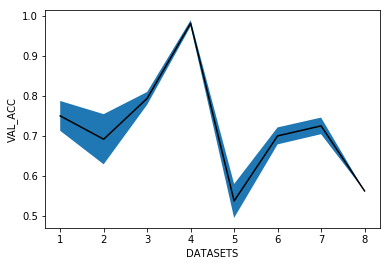

In [40]:
from scipy import stats

SE = stats.sem(VAL_ACC[0:8,:], axis=1)
M = np.mean(VAL_ACC[0:8,:], axis=1)

x = list(range(1,9))
plt.plot(x, M, 'k-')
plt.fill_between(x, M-SE, M+SE)
plt.xticks(x)
plt.xlabel('DATASETS')
plt.ylabel('VAL_ACC')
plt.show()